In [60]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

import pandas as pd
from matplotlib import pyplot as plt
from uncertainties import unumpy as unp
import  uncertainties as unc
import numpy as np
import math
import MySQLdb as mdb

from sys import path
path.append('../')
from emc import get_dimuon_df, get_spill_df, emc_analysis, plot_three_emc

%autoreload 2
%aimport emc

### Objectives
1. Create analysis schema and table
2. Get dimuons and spill (proton) data that satisfies specified criteria
3. Apply efficiencies to dimuons with tracks with known road efficiencies
4. Find dimuons where tracks have unknown roadID's
5. Change roadID to closest known roadID
6. Re-apply efficiencies
7. Specify $x_2$ bin edges and roadset run ranges
8. Calculate EMC ratio for each run range
9. Combine EMC ratio values into a single weighted sum
10. Plot values over E-772 data

Note: set preferences in *emc.cfg* first!

In [3]:
server = 'e906-db3.fnal.gov'
analysis_schema = 'user_dannowitz_roadeff'
analysis_table = 'kDimuon_copy'
merged_schema_list = ['merged_roadset57_R005_V001',
                      'merged_roadset59_R005_V001',
                      'merged_roadset62_R005_V001',
                      'merged_roadset67_R005_V001',
                      'merged_roadset70_R005_V001']
# If fresh start == True, re-apply all cuts (takes ~10min)
fresh_start = False
#fresh_start = True

In [4]:
# Get valid target dimuons
dimuon_df = get_dimuon_df(server=server, 
                          analysis_schema=analysis_schema, 
                          source_schema_list=merged_schema_list,
                          analysis_table=analysis_table,
                          fresh_start=fresh_start)

In [5]:
print "Before Intensity Cut:", len(dimuon_df)
dimuon_df = dimuon_df.query("0 < Intensity_p < 100000")
print "After Intensity Cut:", len(dimuon_df)

Before Intensity Cut: 86991
After Intensity Cut: 86934


In [6]:
# Get spill data from specified spills
spill_df = get_spill_df(server=server,
                        analysis_schema=analysis_schema,
                        merged_schema_list=merged_schema_list)

## Road Class Definition

A road defines a path through the hodoscope elements.

In [44]:
class Road:
        
    def __init__(self, roadID=None, H1=None, H2=None, H3=None, 
                 H4=None, detectorHalf=None):
        self.CONST_H1 = 16*16*16
        self.CONST_H2 = 16*16
        self.CONST_H3 = 16
        self.CONST_H4 = 1
        if roadID:
            self.roadID = roadID
            self.detectorHalf = self.getTB()
            self.H1 = self.getH1ElementID()
            self.H2 = self.getH2ElementID()
            self.H3 = self.getH3ElementID()
            self.H4 = self.getH4ElementID()    
        elif all([H1, H2, H3, H4, detectorHalf]):
            self.detectorHalf = detectorHalf
            self.H1 = H1
            self.H2 = H2
            self.H3 = H3
            self.H4 = H4
            self.roadID = self.getRoadID()
        else:
            print ("Must define either (roadID) or (H1, H2, H3, H4, detectorHalf)")
    
    def getTB(self):
        if self.roadID > 0:
            return "T"
        else:
            return "B"

    def getH1ElementID(self):
        elementID = (abs(self.roadID)-1)//self.CONST_H1 + 1
        return elementID

    def getH2ElementID(self):
        elementID = ((abs(self.roadID)-1)//self.CONST_H2)%16 + 1
        return elementID

    def getH3ElementID(self):
        elementID = ((abs(self.roadID)-1)//self.CONST_H3)%16 + 1
        return elementID

    def getH4ElementID(self):
        elementID = ((abs(self.roadID)-1)//self.CONST_H4)%16 + 1
        return elementID
    
    def getRoadID(self):
        roadID = (self.H1-1)*self.CONST_H1 + (self.H2-1)*self.CONST_H2 + \
                 (self.H3-1)*self.CONST_H3 + self.H4*self.CONST_H4
        if self.detectorHalf == "B":
            roadID *= -1
        return roadID

    def info(self):
        print ("roadID: %d\ndetectorHalf: %s\nH1: %d\nH2: %d\nH3: %d\nH4: %d" %
               (self.roadID, self.detectorHalf, self.H1, self.H2, self.H3, self.H4))

### A function for calculating the known road that most closely resembles the given road

$$ D(X\ \vert\ Y) = \sqrt{3(X_{H1} - Y_{H1})^2 + 2(X_{H2} - Y_{H2})^2 + (X_{H3} - Y_{H3})^2} $$
$$ R = \arg \min_{X \in RS} D(X\ \vert\ Y)$$

*Note*: Since the efficiency position-dependence varies most drastically in H1 and H2, respectively, we put added weight on those differences.

In [8]:
trigger_roads = pd.read_csv('data/triggerroads.csv', sep='\t', index_col='roadID')
trigger_roads.head(5)

,detectorHalf,H1,H2,H3,H4
roadID,,,,,
-77294,B,19,14,15,14
-77293,B,19,14,15,13
-77277,B,19,14,14,13
-77276,B,19,14,14,12
-77260,B,19,14,13,12


In [35]:
def closest_road(road_df, roadID):
    my_road = Road(roadID=roadID)
    my_road_df = road_df.query('detectorHalf == @my_road.detectorHalf').copy()
    my_road_df['distance'] = my_road_df.apply(
        lambda x: math.sqrt(3*(x.H1 - my_road.H1)**2 + 2*(x.H2 - my_road.H2)**2 + \
                            (x.H3 - my_road.H3)**2), axis=1)
    return my_road_df.distance.argmin()

### Use this to assign an efficiency to an unknown roadID

In [51]:
try:
    db = mdb.connect(read_default_file='../.my.cnf',
                     read_default_group='guest',
                     host=server,
                     db=analysis_schema)
    roadeff_query = """SELECT * FROM road_eff2"""
    roadeff_df = pd.read_sql(roadeff_query, db, index_col=['target', 'roadID', 'min_intensity',
                                                           'intensity', 'max_intensity'])
    db.close()
except mdb.Error, e:
    print ("Error %d: %s" % (e.args[0], e.args[1]))

roadeff_df.head(10)

efficiency  uncertainty
target roadID min_intensity intensity max_intensity                         
1      -56832 0             5000      10000               0.980     0.070000
              10000         15000     20000               0.970     0.069642
              20000         25000     30000               0.955     0.069101
              30000         35000     40000               0.925     0.068007
              40000         45000     50000               0.875     0.066144
              50000         55000     60000               0.870     0.065955
              60000         65000     70000               0.905     0.067268
              70000         75000     80000               0.825     0.064226
              80000         85000     90000               0.870     0.065955
              90000         95000     100000              0.770     0.062048

In [52]:
def closest_eff(road_df, roadeff_df, roadID, intensity, target):
    closest_roadID = closest_road(road_df, roadID)
    query = "roadID == @closest_roadID and min_intensity <= @intensity < max_intensity and target==@target"
    entry = roadeff_df.query(query)
    if len(entry.efficiency.values) == 0:
        return None
    return entry.efficiency.values[0]

In [53]:
def fill_in_eff(df, road_df, roadeff_df):
    for idx, data in df[dimuon_df['negRoadEff'].isnull()][['negRoadID', 'Intensity_p', 'targetPos']].iterrows():
        eff = closest_eff(trigger_roads, roadeff_df, data.negRoadID, data.Intensity_p, data.targetPos)
        df.loc[idx,'negRoadEff'] = eff
    for idx, data in df[dimuon_df['posRoadEff'].isnull()][['posRoadID', 'Intensity_p', 'targetPos']].iterrows():
        eff = closest_eff(trigger_roads, roadeff_df, data.posRoadID, data.Intensity_p, data.targetPos)
        df.loc[idx,'posRoadEff'] = eff
    return df

In [56]:
dimuon_df.loc[0, 'posRoadEff'] = np.NaN

In [57]:
print "Number of dimuons missing negRoadEff:", len(dimuon_df[dimuon_df['negRoadEff'].isnull()])
print "Number of dimuons missing posRoadEff:", len(dimuon_df[dimuon_df['posRoadEff'].isnull()])

Number of dimuons missing negRoadEff: 0
Number of dimuons missing posRoadEff: 1


In [58]:
dimuon_df = fill_in_eff(dimuon_df, trigger_roads, roadeff_df)

In [59]:
print "Number of dimuons missing negRoadEff:", len(dimuon_df[dimuon_df['negRoadEff'].isnull()])
print "Number of dimuons missing posRoadEff:", len(dimuon_df[dimuon_df['posRoadEff'].isnull()])

Number of dimuons missing negRoadEff: 0
Number of dimuons missing posRoadEff: 0


In [22]:
dimuon_df.to_csv('dimuon_roadeff.tsv', sep='\t')
spill_df.to_csv('spill_roadeff.tsv', sep='\t')

In [29]:
# Establish run ranges and x_2 bin edges 
run_ranges = [(8912, 10420), (11075, 12438), (12525, 15789)]
bin_edges = [0.08, 0.14, 0.16, 0.18, 0.21, 0.25, 0.31, 0.53]

In [30]:
emc_df_corrected, means_list_corrected, avg_means_df_corrected = \
    emc_analysis(dimuon_df, spill_df, run_ranges, bin_edges, qie_correction=True)
emc_df, means_list, avg_means_df = \
    emc_analysis(dimuon_df, spill_df, run_ranges, bin_edges, qie_correction=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe11a2fe310>]], dtype=object)

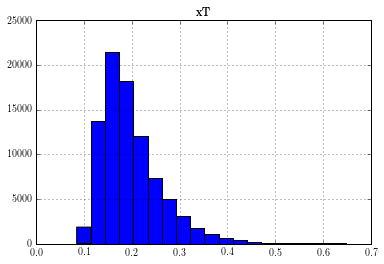

In [66]:
dimuon_df.hist('xT', bins=20)

In [64]:
means_list[2].bar('ncounts_bg')

AttributeError: 'DataFrame' object has no attribute 'bar'

In [31]:
emc_df_corrected

,xT,D/H,C/D,Fe/D,W/D,C/H,Fe/H,W/H,Fe/C,W/C,W/D(iso),W/C(iso),Fe/D(iso),Fe/C(iso)
"(0.08, 0.14]",0.126+/-0.006,1.20+/-0.04,0.96+/-0.04,0.98+/-0.04,0.903+/-0.032,1.14+/-0.05,1.18+/-0.05,1.09+/-0.05,0.96+/-0.04,0.88+/-0.04,0.874+/-0.032,0.85+/-0.04,0.97+/-0.04,0.94+/-0.04
"(0.14, 0.16]",0.1502+/-0.0033,1.13+/-0.04,1.05+/-0.04,1.05+/-0.04,1.007+/-0.034,1.20+/-0.05,1.19+/-0.05,1.15+/-0.05,0.99+/-0.04,0.96+/-0.04,0.984+/-0.034,0.93+/-0.04,1.04+/-0.04,0.98+/-0.04
"(0.16, 0.18]",0.1698+/-0.0033,1.19+/-0.04,1.03+/-0.04,1.04+/-0.04,1.043+/-0.033,1.23+/-0.05,1.24+/-0.05,1.25+/-0.05,1.00+/-0.04,1.01+/-0.04,1.010+/-0.033,0.98+/-0.04,1.027+/-0.035,0.99+/-0.04
"(0.18, 0.21]",0.194+/-0.005,1.200+/-0.035,1.09+/-0.04,1.075+/-0.033,1.017+/-0.030,1.31+/-0.05,1.29+/-0.05,1.22+/-0.04,0.99+/-0.04,0.930+/-0.033,0.984+/-0.029,0.900+/-0.032,1.063+/-0.033,0.98+/-0.04
"(0.21, 0.25]",0.228+/-0.006,1.19+/-0.04,1.10+/-0.04,1.10+/-0.04,1.081+/-0.035,1.31+/-0.06,1.30+/-0.06,1.29+/-0.05,0.99+/-0.04,0.98+/-0.04,1.047+/-0.035,0.95+/-0.04,1.08+/-0.04,0.98+/-0.04
"(0.25, 0.31]",0.275+/-0.010,1.11+/-0.04,1.08+/-0.05,1.02+/-0.04,0.99+/-0.04,1.23+/-0.06,1.12+/-0.05,1.10+/-0.05,0.93+/-0.04,0.90+/-0.04,0.97+/-0.04,0.88+/-0.04,1.02+/-0.04,0.93+/-0.04
"(0.31, 0.53]",0.360+/-0.026,1.14+/-0.06,1.04+/-0.07,1.03+/-0.06,1.10+/-0.06,1.19+/-0.09,1.19+/-0.08,1.25+/-0.08,0.94+/-0.07,1.04+/-0.07,1.07+/-0.06,1.02+/-0.07,1.03+/-0.06,0.93+/-0.06


In [32]:
bin_centers = unp.nominal_values(emc_df['xT'].values)
lower_val = np.subtract(bin_centers,bin_edges[:-1])
upper_val = np.subtract(bin_edges[1:], bin_centers)
asymmetric_bars = [lower_val, upper_val]

In [33]:
# Store the E772 results
e772_dict = {}
# DY Ratio for C/D vrs Xtgt - E772
# --------------------------------
e772_dict['C/D'] = {}
e772_dict['C/D']['xT'] = [0.041, 0.062, 0.087, 0.111, 0.136, 0.161, 0.186, 0.216, 0.269]
e772_dict['C/D']['ratio'] = unp.uarray([0.981, 0.974, 1.013, 1.011, 0.979, 1.049, 1.117, 1.151, 1.044],
                                        [0.017, 0.014, 0.016, 0.020, 0.027, 0.044, 0.074, 0.110, 0.202])

# DY Ratio for Fe/D vrs Xtgt - E772
# --------------------------------
e772_dict['Fe/D'] = {}
e772_dict['Fe/D']['xT'] = [0.041, 0.062, 0.087, 0.111, 0.136, 0.161, 0.186, 0.219, 0.271]
e772_dict['Fe/D']['ratio'] = unp.uarray([0.954, 0.976, 1.009, 0.992, 0.984, 1.009, 0.953, 1.016, 0.984],
                                         [0.014, 0.011, 0.012, 0.014, 0.018, 0.027, 0.037, 0.050, 0.088])

# DY Ratio for W/D vrs Xtgt - E772
# --------------------------------
e772_dict['W/D'] = {}
e772_dict['W/D']['xT'] = [0.041, 0.062, 0.087, 0.111, 0.136, 0.161, 0.186, 0.216, 0.269]
e772_dict['W/D']['ratio'] = unp.uarray([0.954, 0.976, 1.009, 0.992, 0.984, 1.009, 0.953, 1.016, 0.984],
                                        [0.016, 0.013, 0.016, 0.020, 0.026, 0.043, 0.067, 0.099, 0.192])

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


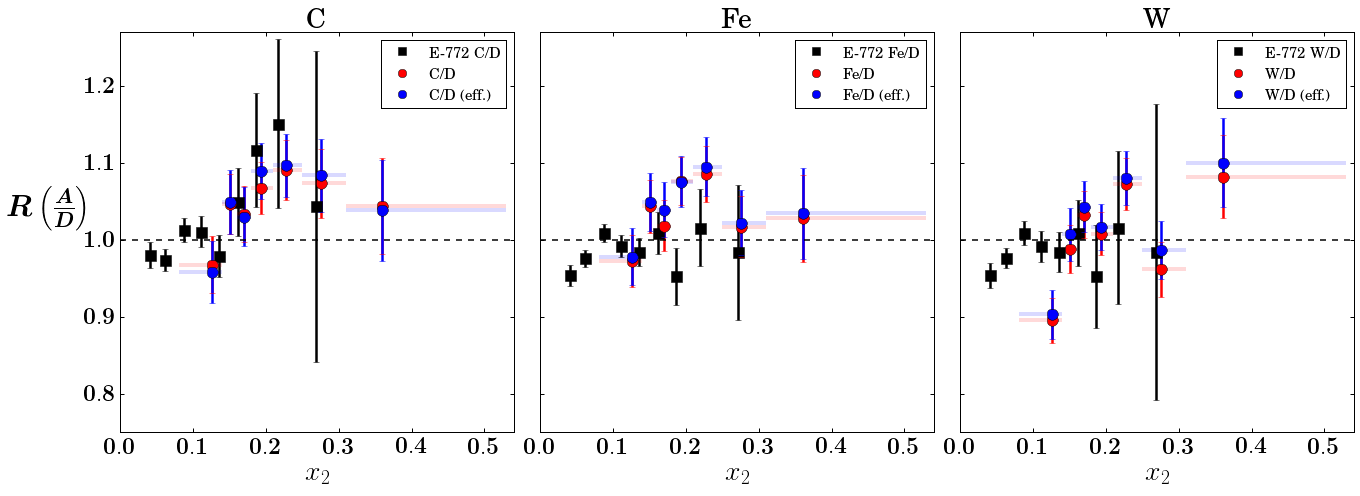

In [34]:
plot_three_emc(bin_centers, asymmetric_bars,
               [emc_df['C/D'], emc_df_corrected['C/D']],
               ['C/D', 'C/D (eff.)'],
               [emc_df['Fe/D'], emc_df_corrected['Fe/D']],
               ['Fe/D', 'Fe/D (eff.)'],
               [emc_df['W/D'], emc_df_corrected['W/D']],
               ['W/D', 'W/D (eff.)'])

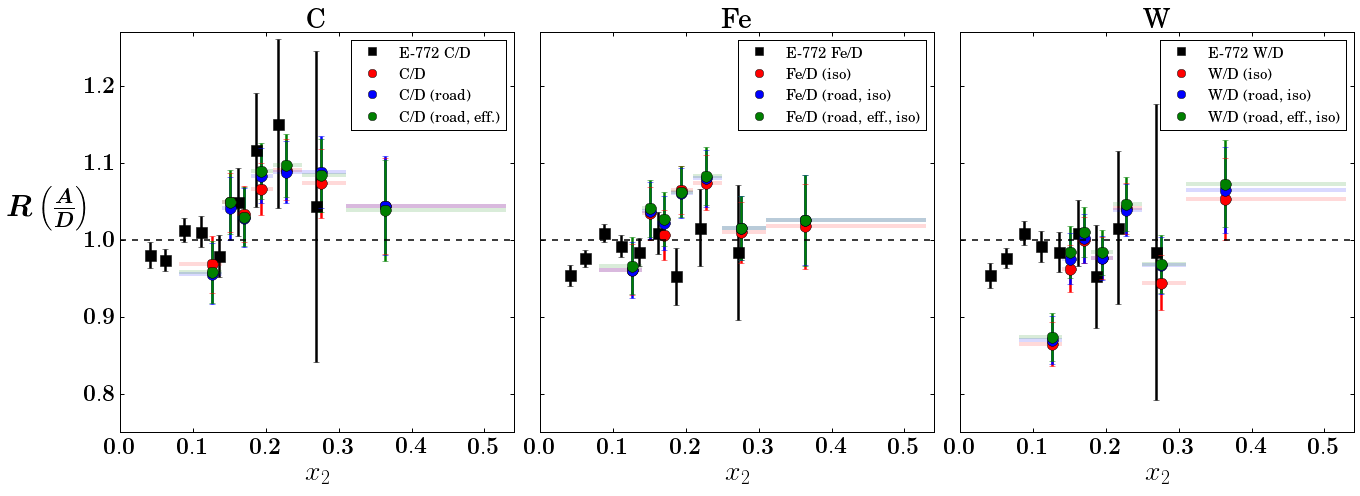

In [74]:
plot_three_emc(bin_centers, asymmetric_bars,
               [full_emc_df['C/D'], emc_df['C/D'], emc_df_corrected['C/D']],
               ['C/D', 'C/D (road)', 'C/D (road, eff.)'],
               [full_emc_df['Fe/D(iso)'], emc_df['Fe/D(iso)'], emc_df_corrected['Fe/D(iso)']],
               ['Fe/D (iso)', 'Fe/D (road, iso)', 'Fe/D (road, eff., iso)'],
               [full_emc_df['W/D(iso)'], emc_df['W/D(iso)'], emc_df_corrected['W/D(iso)']],
               ['W/D (iso)', 'W/D (road, iso)', 'W/D (road, eff., iso)'])

In [20]:
qie_systematic = {'C/D': 0.0396630986042,
                  'Fe/D': 0.0606710075894,
                  'W/D': 0.0396895838982}
total_systematic = {}
for target in sys_diff:
     total_systematic[target] = np.sqrt(np.square(sys_diff[target]) + qie_systematic[target]**2) 

In [21]:
zipset = zip(bin_edges[:-1],bin_edges[1:])   
rangeset = []
fillvalues = {}

for ratio in ('C/D', 'Fe/D', 'W/D'):
    fillvalues[ratio] = []
    for i in range(len(total_systematic[ratio])):
        fillvalues[ratio].append(total_systematic[ratio][i])
        fillvalues[ratio].append(total_systematic[ratio][i])
    fillvalues[ratio] = np.array(fillvalues[ratio])

for pair in zipset:
    rangeset.append(pair[0])
    rangeset.append(pair[1])
    
rangeset = np.array(rangeset)
bottom = 0.77*np.ones_like(rangeset)

{'W/D': array([ 0.04035796,  0.04035796,  0.04040575,  0.04040575,  0.04043381,
        0.04043381,  0.04041889,  0.04041889,  0.04042744,  0.04042744,
        0.04036565,  0.04036565,  0.0405603 ,  0.0405603 ]), 'C/D': array([ 0.04018309,  0.04018309,  0.04025956,  0.04025956,  0.04023195,
        0.04023195,  0.04032557,  0.04032557,  0.0402735 ,  0.0402735 ,
        0.0402362 ,  0.0402362 ,  0.0404907 ,  0.0404907 ]), 'Fe/D': array([ 0.06106183,  0.06106183,  0.06114859,  0.06114859,  0.06107235,
        0.06107235,  0.06118214,  0.06118214,  0.06107895,  0.06107895,
        0.06108974,  0.06108974,  0.06109465,  0.06109465])}
[ 0.08  0.14  0.14  0.16  0.16  0.18  0.18  0.21  0.21  0.25  0.25  0.31
  0.31  0.53]
[ 0.77  0.77  0.77  0.77  0.77  0.77  0.77  0.77  0.77  0.77  0.77  0.77
  0.77  0.77]


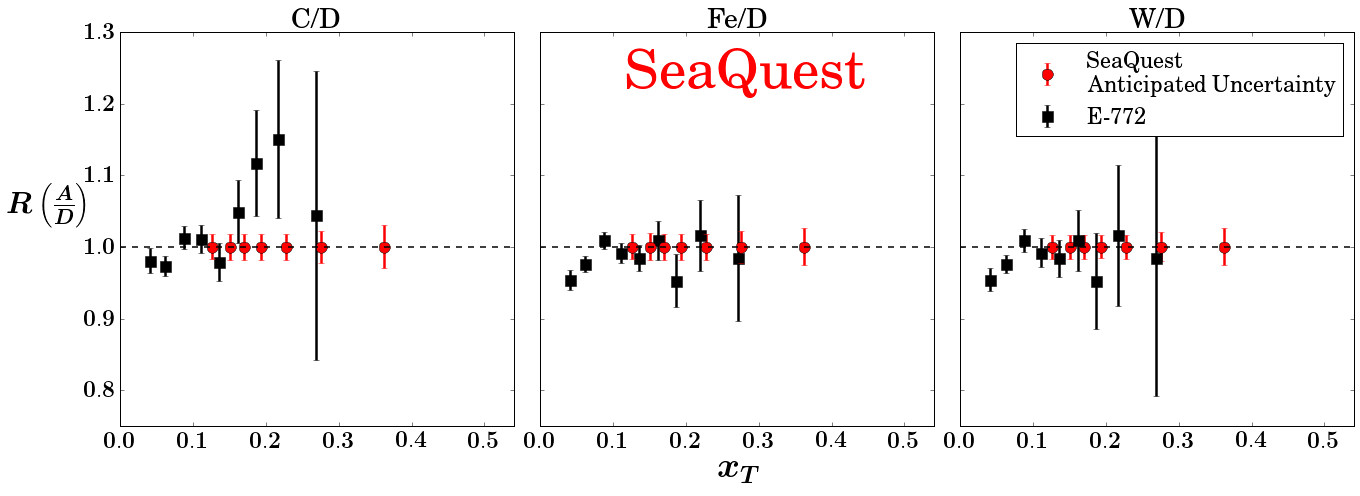

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(19,7))

ax1.set_title('C/D', fontsize=28)
ax1.errorbar(e772_dict['C/D']['bin_centers'], unp.nominal_values(e772_dict['C/D']['uratio']),
            unp.std_devs(e772_dict['C/D']['uratio']), fmt='s', ms=11, elinewidth=2.5, color='black', label='E-772 C/D') 
ax1.errorbar(bin_centers, np.ones_like(unp.nominal_values(emc_df['C/D'].values)),
             yerr=np.divide(unp.std_devs(emc_df['C/D'].values),np.sqrt(10)),
             fmt='o', ms=11, elinewidth=2.5, color='red', label='SeaQuest')
ax1.axhline(y=1, c='black', ls='--', linewidth=1.5)
ax1.set_ylabel(r'$\boldsymbol{R \left(\frac{A}{D}\right)}$', fontsize=30, rotation=0, labelpad=35)
plt.setp(ax1.get_xticklabels(), fontsize=23)
plt.setp(ax1.get_yticklabels(), fontsize=23)

ax2.set_title('Fe/D', fontsize=28)
ax2.errorbar(e772_dict['Fe/D']['bin_centers'], unp.nominal_values(e772_dict['Fe/D']['uratio']),
            unp.std_devs(e772_dict['Fe/D']['uratio']), fmt='s', ms=11, elinewidth=2.5, color='black', label='E-772 Fe/D') 
ax2.errorbar(bin_centers, np.ones_like(unp.nominal_values(emc_df['Fe/D(iso)'].values)),
             yerr=np.divide(unp.std_devs(emc_df['Fe/D(iso)'].values),np.sqrt(10)),
             fmt='o', ms=11, elinewidth=2.5, color='red', label='SeaQuest')
ax2.set_xlabel(r'$\boldsymbol{x_T}$', fontsize=35)
ax2.axhline(y=1, c='black', ls='--', linewidth=1.5)
plt.setp(ax2.get_xticklabels(), fontsize=23)

ax3.set_title('W/D', fontsize=28)
ax3.errorbar(bin_centers, np.ones_like(unp.nominal_values(emc_df['W/D(iso)'].values)),
             yerr=np.divide(unp.std_devs(emc_df['W/D(iso)'].values),np.sqrt(10)),
             fmt='o', ms=11, elinewidth=2.5, color='red', label='SeaQuest\nAnticipated Uncertainty')
ax3.errorbar(e772_dict['W/D']['bin_centers'], unp.nominal_values(e772_dict['W/D']['uratio']),
            unp.std_devs(e772_dict['W/D']['uratio']), fmt='s', ms=11, elinewidth=2.5, color='black', label='E-772') 
ax3.axhline(y=1, c='black', ls='--', linewidth=1.5)
ax3.legend(loc='best', fontsize=22, numpoints=1)
plt.setp(ax3.get_xticklabels(), fontsize=23)

xtick_locs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
ytick_locs = [0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plt.xticks(xtick_locs, [r"$\mathbf{%.1f}$" % x for x in xtick_locs]) 
plt.yticks(ytick_locs, [r"$\mathbf{%.1f}$" % x for x in ytick_locs]) 

f.text(0.95, 0.05, 'SeaQuest',
         fontsize=55, color='red',
         position=(0.46, 0.82))

ax3.axis((0, 0.54, 0.75, 1.3))

plt.tight_layout()
plt.setp([a.get_yticklabels() for a in f.axes[1:]], visible=False)
plt.setp([a.get_xticklines() for a in f.axes[:]], lw=20)
plt.show()